# Model 2:
- confusion matrix and explain features
- barplot of most recurring words
- bigram, tri, etc. most common words
- remove eli5
- word count charter count
- look at miss classifications


## Import Libraries

In [1]:
import datetime
import time
import requests
import pandas as pd
import numpy as np
from spellchecker import SpellChecker
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt


## Pulling Functions

In [2]:

def get_subreddit_df(subreddit, max_size=1000):
    '''
    give function a subreddit string returns df of all 
    '''
    # base url
    base_url = 'https://api.pushshift.io/reddit/search/'
    # return df
    df = pd.DataFrame()
    # initial params
    params = {
        'subreddit' : subreddit, # /r page
        'size' : 500, # get max size
        'over_18': 'false', # remove nsfw posts
        'before': 1650603966, # start date
        'after': 1648875966, # end date
        'is_video': False
    }
    # loop to get df of elements
    while df.shape[0] < max_size:
        res = requests.get(base_url + 'submission/', params = params)
        # check if request cant pull
        if res.status_code != 200:
            print(f'Issue Pulling Data :: status code :: {res.status_code}')
            return df
        # make current timefram df
        current_df = pd.DataFrame(res.json()['data'])[['subreddit', 'selftext', 'title']]
        current_df['title'] = current_df['title']
        # add current df to historical df
        df = pd.concat([df, current_df], axis=0)
        # decrese start time - 20 days
        before_dt_time = datetime.datetime.fromtimestamp(params['before'])
        new_dt_b = before_dt_time - datetime.timedelta(days=20)
        params['before'] = int(new_dt_b.strftime('%s'))
        # decrease end time - 20 days
        after_dt_time = datetime.datetime.fromtimestamp(params['after'])
        new_dt_a = after_dt_time - datetime.timedelta(days=20)
        params['after'] = int(new_dt_a.strftime('%s'))
        # added sleep to not cause 429 error :: to mant pulls
        time.sleep(3)
    return df

def clean_df(df, col=''):
    copy_df = df.copy()
    # remove all string that contain 'elif'
    copy_df[col] = copy_df[col].str.lower()
    copy_df[col] = copy_df[col].str.replace('eli5', '')
    # # remove the numeric
    copy_df = copy_df[~copy_df[col].str.contains('\d')]
    print(copy_df.shape)
    # correct the spelling of sentences
    spell = SpellChecker()
    copy_df[f'corrected_{col}'] = [spell.split_words(sentence.translate(str.maketrans('', '', string.punctuation)).lower()) for sentence in copy_df[col]]
    print(copy_df.shape)
    return copy_df


## Import Subreddit DF's

In [3]:
explain_like_im_five_df = get_subreddit_df('explainlikeimfive', max_size=5000)
# explain_like_im_five_df['subreddit'] = 1
shower_thoughts = get_subreddit_df('NoStupidQuestions', max_size=5000)
# shower_thoughts['subreddit'] = 0

In [4]:
subredt_joined_df = pd.concat([clean_df(explain_like_im_five_df, col='title'), clean_df(shower_thoughts, col='title')], axis=0)

(4695, 3)
(4695, 4)
(4628, 3)
(4628, 4)


In [5]:
subredt_joined_df['subreddit'].value_counts(normalize=True)

explainlikeimfive    0.503593
NoStupidQuestions    0.496407
Name: subreddit, dtype: float64

## Count Vectorizer

In [6]:
X = subredt_joined_df['corrected_title'].str.join(' ')
y = subredt_joined_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [7]:
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union([])

In [8]:
y.value_counts(normalize=True)

explainlikeimfive    0.503593
NoStupidQuestions    0.496407
Name: subreddit, dtype: float64

In [9]:
cv = CountVectorizer(stop_words='english')

cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)
# cv.score(X_train_cv, y_train), cv.score(X_test_cv, y_test)

In [10]:
text_df = pd.DataFrame(data=X_train_cv.A, columns=cv.get_feature_names_out())
text_df

,aaa,aaaa,aaaaaa,aak,aampw,aaron,aave,ab,abdomen,ability,...,zombies,zone,zoning,zoo,zoom,zoomies,zooming,zoos,zuckerberg,zzquil
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Testing Different Models

### RandomForestClassifier GridSerachCV

- train: 0.9961384439359268
- test: 0.6675246675246675
- best_params: {'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 500}

In [65]:
rfc = RandomForestClassifier()
rfc_params = {
    'n_estimators': [100, 500, 700],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 7],
}
gs = GridSearchCV(
    rfc,
    rfc_params,
    cv=5,
    n_jobs=-1
)
gs.fit(X_train_cv, y_train)
gs.score(X_train_cv, y_train), gs.score(X_test_cv, y_test), gs.best_params_

(0.9961384439359268,
 0.6675246675246675,
 {'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 500})

### ExtraTreesClassifier GridSearchCV

- train: 0.9967105263157895
- test: 0.6718146718146718
- best_params: {'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 500} 

In [73]:
etc = ExtraTreesClassifier()
etc_params = {
    'n_estimators': [100, 500, 700],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 7],
}
gs = GridSearchCV(
    etc,
    etc_params,
    cv=5,
    n_jobs=-1
)
gs.fit(X_train_cv, y_train)
gs.score(X_train_cv, y_train), gs.score(X_test_cv, y_test), gs.best_params_

(0.9967105263157895,
 0.6718146718146718,
 {'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 500})

### KNeighborsClassifier GridSearchCV

- train: 0.9967105263157895
- test: 0.5272415272415273,
- best_params: {'p': 2, 'weights': 'distance'}

In [72]:
knnc = KNeighborsClassifier(n_jobs=-1)
knnc_params = {
    'weights': ['uniform', 'distance'],
    'p': [1, 2] 
}
gs = GridSearchCV(
    knnc,
    knnc_params,
    cv=5,
    n_jobs=-1
)
gs.fit(X_train_cv, y_train)
gs.score(X_train_cv, y_train), gs.score(X_test_cv, y_test), gs.best_params_

(0.9967105263157895, 0.5272415272415273, {'p': 2, 'weights': 'distance'})

### DecisionTreeClassifier GridSearchCV

- train: 0.9967105263157895
- test: 0.6233376233376233,
- best_params: {'criterion': 'gini', 'max_features': 'auto', 'splitter': 'best'}

In [71]:
dtc = DecisionTreeClassifier(random_state=42)
dtc_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': ['auto', 'sqrt', 'log2']
}
gs = GridSearchCV(
    dtc,
    dtc_params,
    cv=5,
    n_jobs=-1
)
gs.fit(X_train_cv, y_train)
gs.score(X_train_cv, y_train), gs.score(X_test_cv, y_test), gs.best_params_

(0.9967105263157895,
 0.6233376233376233,
 {'criterion': 'gini', 'max_features': 'auto', 'splitter': 'best'})

### GaussianNB GridSearchCV

- train: 0.9898455377574371
- test: 0.6040326040326041,
- best_params: {'var_smoothing': 1e-09}

In [69]:
gnb = GaussianNB()
gnb_params = {
    'var_smoothing': np.arange(0.000000001, 0.0005, .0005)
}
gs = GridSearchCV(
    gnb,
    gnb_params,
    cv=5,
    n_jobs=-1
)
gs.fit(X_train_cv.A, y_train)
gs.score(X_train_cv.A, y_train), gs.score(X_test_cv.A, y_test), gs.best_params_

(0.9898455377574371, 0.6040326040326041, {'var_smoothing': 1e-09})

### LogisticRegression GridSearchCV

- train: 0.988558352402746
- test: 0.6889746889746889,
- best_params: {'C': 1, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 3, 'penalty': 'l2', 'solver': 'saga'}

In [66]:
lr = LogisticRegression(max_iter=10_000)
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'fit_intercept': [True, False],
    'intercept_scaling': [1,3,7],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C':[.1,1,10]
}
gs = GridSearchCV(
    lr,
    lr_params,
    cv=5,
    n_jobs=-1
)
gs.fit(X_train_cv, y_train)
gs.score(X_train_cv, y_train), gs.score(X_test_cv, y_test), gs.best_params_

/Users/robertsarno/Documents/Spring_2022/Learning/General_Assembly/GA_lib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertsarno/Documents/Spring_2022/Learning/General_Assembly/GA_lib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertsarno/Documents/Spring_2022/Learning/General_Assembly/GA_lib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertsarno/Documents/Spring_2022/Learning/General_Assembly/GA_lib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertsarno/Documents/Spring_2022/Learning/Ge

(0.988558352402746,
 0.6889746889746889,
 {'C': 1,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 3,
  'penalty': 'l2',
  'solver': 'saga'})

## Initial Model

In [11]:
vc1 = VotingClassifier(
    [('lr', LogisticRegression(max_iter=10000, C=1, dual=False, fit_intercept=True, intercept_scaling=3, penalty='l2', solver='saga')),
    #  ('rfc', RandomForestClassifier(random_state=123, criterion='entropy', min_samples_split=4, n_estimators=500)),
    #  ('etc', ExtraTreesClassifier(random_state=123, criterion='entropy', min_samples_split=4, n_estimators=500))
    ],
    weights=[1],
    n_jobs=-1
)
vc1.fit(X_train_cv, y_train)
vc1.score(X_train_cv, y_train), vc1.score(X_test_cv, y_test)

(0.9292048054919908, 0.6700986700986701)

<Figure size 1080x720 with 0 Axes>

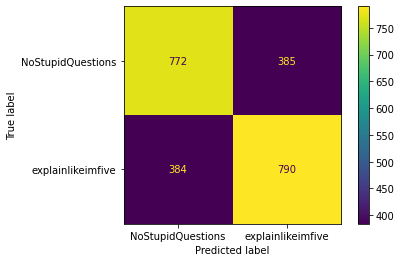

In [12]:
plt.figure(figsize=(15,10))
ConfusionMatrixDisplay.from_estimator(vc1, X_test_cv, y_test)
plt.savefig("../img/cm_inital_model.png")
plt.show()